<center> <h1>Trabajo final para la asignatura APBD</h1> </center>
<center> <h3>Máster en Data Science y Big Data. CFP-Universidad de Sevilla</h3> </center>
<p style="text-align: center;">Autor: Inmaculada Perea Fernández</p>
<p style="text-align: center;">(Julio 2017)</p>


# Tabla de contenidos

1. [Descripción del problema](#descripcion)

2. [Inicio sesión Spark](#inicio)

3. [Lectura de datos y exploración](#exploracion)

4. [Preprocesado](#preprocesado)

    4.1. [Valores perdidos (missings)](#missings)
    
    4.2. [Conversión a tipo numérico](#numerico)
    
    4.3. [Escalado](#escalado)
    
    4.4. [Convertir features en vector](#features)
    
5. [Selección de variables](#seleccion)

6. [Modelos](#modelos)

    6.1. [Ajuste de parámetros](#ajuste)
    
    6.2. [Evaluación](#evaluacion)
       
7. [Cierre sesión spark](#cierre)


<a id='descripcion'></a>

# Descripción del problema

El problema elegido para el trabajo es uno de los datasets de aprendizaje de kaggle, en el que el objetivo es predecir el precio de venta de viviendas a partir de sus características

Para más información sobre el problema ir a https://www.kaggle.com/c/house-prices-advanced-regression-techniques

El objetivo de este trabajo es practicar con las diferentes herramientas que *Spark* nos proporciona para el procesamiento distribuido de grandes cantidades de datos, y para la aplicación de técnicas de machine learning. La obtención de predicciones óptimas es un objetivo secundario aunque se valorará positivamente.

Las APIs de Spark más importantes para este proyecto serán la API de DataFrames y la API de ML para DataFrames. También tenemos a nuestra disposición la API RDDs para procesamiento a bajo nivel, y la API MLlib para RDDs.

<a id="inicio"></a>

# Inicio sesión spark

Creamos la sesión spark como punto de entrada para poder trabajar con la API de DataFrame

In [1]:
import sys

# Ruta de la carpeta local Spark.
spark_path = 'C:/Users/inpf/spark-2.1.0-bin-hadoop2.7'

sys.path.append(spark_path + '/python')
sys.path.append(spark_path + '/python/lib/py4j-0.10.4-src.zip')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("evaluacion_APBD_InmaPerea").getOrCreate()

spark

Comprobamos el número de cores asignados

In [2]:
spark.sparkContext.defaultParallelism

4

# Carga de librerías

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql import Row

from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Se importa sum como agg_sum para evitar colisión de nombres
from pyspark.sql.functions import lit, col, count, sum as agg_sum
from pyspark.sql.functions import expr, udf, regexp_extract
from pyspark.sql.functions import desc, avg, round as col_round


from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt

# Establecimiento Semilla

Establecemos la semilla que usaremos para toda la práctica

In [4]:
global_seed = 123456789

<a id="exploracion"></a>

# 3. Lectura de datos

Para explorar uniremos ambos datasets train y test. Por tanto cargaremos ambos datasets para su unión y posterior exploración.

In [5]:
path = './data/'

train = spark.read.csv(path +'train.csv', header=True, inferSchema=True, nullValue="NA").cache()
test  = spark.read.csv(path +'test.csv', header=True, inferSchema=True, nullValue="NA").cache()

Comprobaremos si ambos datasets tienen las mismas dimensiones y esquema antes de unirlos

In [6]:
print('Numero columnas para cada conjunto de datos ')
print('- train = {}'.format(len(train.schema.fields)))
print('- test  = {}'.format(len(test.schema.fields)))

Numero columnas para cada conjunto de datos 
- train = 81
- test  = 80


Observamos que tienen dimensiones distintas, esto es debido a que en el conjunto *test* no existe la columna correspondiente a la variable respuesta *SalePrice*. Vamos a añadir dicha columna al conjunto *test*.

Consultamos el tipo de dato de la columna *SalePrice* para replicarlo en el conjunto test.

In [7]:
train.schema['SalePrice']

StructField(SalePrice,IntegerType,true)

Creamos la columna en el conjunto *test* con el mismo tipo que en el conjunto *train*

In [8]:
test = test.withColumn('SalePrice', lit(None).cast(IntegerType()))

Ahora comprobaremos los esquemas de ambos dataframes, el orden de las columnas y su tipo

In [9]:
compare = [False if (train_field != test_field) else True for test_field, train_field in zip (test.schema.fields, train.schema.fields)]
print('¿Ambos dataframes tienen el mismo esquema de datos? {}'.format(False not in compare))

¿Ambos dataframes tienen el mismo esquema de datos? True


In [10]:
full = train.union(test)

print("Número de filas de cada dataframe:")
print("- train = {}".format(train.count()))
print("- test  = {}".format(test.count()))
print("- full  = {}".format(full.count()))

Número de filas de cada dataframe:
- train = 1460
- test  = 1459
- full  = 2919


# 4. Exploración de los datos

El esquema del dataframe union de train + test

In [11]:
full.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [12]:
cols = full.columns
num_columns=len(cols)
print("Número de variables= {}".format(num_columns))

Número de variables= 81


In [13]:
step=7
for index in range(0, num_columns, step):
    full.select(cols[index:index+step]).show(5) 

+---+----------+--------+-----------+-------+------+-----+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|
+---+----------+--------+-----------+-------+------+-----+
|  1|        60|      RL|         65|   8450|  Pave| null|
|  2|        20|      RL|         80|   9600|  Pave| null|
|  3|        60|      RL|         68|  11250|  Pave| null|
|  4|        70|      RL|         60|   9550|  Pave| null|
|  5|        60|      RL|         84|  14260|  Pave| null|
+---+----------+--------+-----------+-------+------+-----+
only showing top 5 rows

+--------+-----------+---------+---------+---------+------------+----------+
|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|
+--------+-----------+---------+---------+---------+------------+----------+
|     Reg|        Lvl|   AllPub|   Inside|      Gtl|     CollgCr|      Norm|
|     Reg|        Lvl|   AllPub|      FR2|      Gtl|     Veenker|     Feedr|
|     IR1|        Lvl|   AllPub|   Inside|      Gtl|     Co

In [14]:
step=5
for index in range(0, num_columns, step):
    full.describe(cols[index:index+step]).show()

+-------+-----------------+------------------+--------+------------------+-----------------+
|summary|               Id|        MSSubClass|MSZoning|       LotFrontage|          LotArea|
+-------+-----------------+------------------+--------+------------------+-----------------+
|  count|             2919|              2919|    2915|              2433|             2919|
|   mean|           1460.0|  57.1377183967112|    null| 69.30579531442663|10168.11408016444|
| stddev|842.7870430897713|42.517627829150314|    null|23.344904706927394|7886.996359105535|
|    min|                1|                20| C (all)|                21|             1300|
|    max|             2919|               190|      RM|               313|           215245|
+-------+-----------------+------------------+--------+------------------+-----------------+

+-------+------+-----+--------+-----------+---------+
|summary|Street|Alley|LotShape|LandContour|Utilities|
+-------+------+-----+--------+-----------+---------+


<a id="missings"></a>

## 4.1 Valores perdidos (missings)

En la lectura de los ficheros csv de datos especificamos "NA" como nullValue.

A continuación vamos a evaluar los valores perdidos del conjunto resultante de la unión de los datasets de test y entrenamiento.

In [15]:
def count_nulls(c):
    return agg_sum(col(c).isNull().cast(IntegerType())).alias(c)

exprs = [count_nulls(c) for c in full.columns]

count_NA = full.agg(*exprs).first().asDict()

total_NA=sorted([(v, k) for k, v in count_NA.items() if v > 0], reverse=True)
total_NA

[(2909, 'PoolQC'),
 (2814, 'MiscFeature'),
 (2721, 'Alley'),
 (2348, 'Fence'),
 (1459, 'SalePrice'),
 (1420, 'FireplaceQu'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (159, 'GarageQual'),
 (159, 'GarageFinish'),
 (159, 'GarageCond'),
 (157, 'GarageType'),
 (82, 'BsmtExposure'),
 (82, 'BsmtCond'),
 (81, 'BsmtQual'),
 (80, 'BsmtFinType2'),
 (79, 'BsmtFinType1'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

In [16]:
print("Número total de variables que presentan valores NA = {}".format(len(total_NA)))

Número total de variables que presentan valores NA = 35


### 4.1.1 Variables con categoría *NA* válida

Obtenemos un total de 35 variables que presentan valores *NA*, sin embargo, al leer el fichero *data_description.txt*, que contiene una breve descripción de las variables, podemos extraer que muchas de las variables faltantes no son verdaderos missings, sino que corresponden a categorías permitidas, o representan la ausencia de una determinada característica, como por ejemplo piscina, garaje, valla, chimenea, sótano, etc.

A continuación definiremos una lista con los nombres de las variables para las que la categoría "NA" es válida, y por tanto las observaciones con este valor no serán tratadas como variables missing. 

In [17]:
allowed_NA=['Alley',
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinType2',
            'FireplaceQu',
            'GarageType',
            'GarageFinish',
            'GarageQual',
            'GarageCond',
            'PoolQC',
            'Fence',
            'MiscFeature']

print('Número de variables con categoría NA permitida = {}'.format(len(allowed_NA)))

Número de variables con categoría NA permitida = 14


Comprobamos el tipo de variable

In [18]:
for var in allowed_NA:
    print(full.schema[var].dataType)

StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType


confirmamos que todas son variables categóricas, como cabía esperar.

Para que quede más claro vamos a cambiar la categoría *NA* de las variables anteriores a las categorías que se presentan a continuación, y que son más descriptivas.

In [19]:
new_NA_categories={'Alley':'noAccess',
                   'BsmtQual':'NoBasement',
                   'BsmtCond':'NoBasement',
                   'BsmtExposure':'NoBasement',
                   'BsmtFinType1':'NoBasement',
                   'BsmtFinType2':'NoBasement',
                   'FireplaceQu':'NoFireplace',
                   'GarageType': 'NoGarage',
                   'GarageFinish':'NoGarage',
                   'GarageQual':'NoGarage',
                   'GarageCond':'NoGarage',
                   'PoolQC':'NoPool',
                   'Fence':'NoFence',
                   'MiscFeature':'None'}

In [20]:
full=full.fillna(new_NA_categories)

In [21]:
missings=sorted([(v, k) for k, v in full.agg(*[count_nulls(c) for c in full.columns]).first().asDict().items() if v > 0], reverse=True)
print('Número de variables con valores perdidos = {}'.format(len(missings)))
missings

Número de variables con valores perdidos = 21


[(1459, 'SalePrice'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

### 4.1.2 Variable missing *SalePrice*

Los valores 1459 valores perdidos que obtenemos para la variable objetivo *SalePrice* pertenecen al conjunto test.

Vamos a asegurarnos de que es así realizando las siguientes comprobaciones:

In [22]:
print('Número de observaciones conjunto test = {}'.format(test.count()))

Número de observaciones conjunto test = 1459


In [23]:
print('Número de valores perdidos para la variable SalePrice en el conjunto train = {}'.format\
      (train.agg(agg_sum(col('SalePrice').isNull().cast(IntegerType())).alias('SalePrice')).first().SalePrice))

Número de valores perdidos para la variable SalePrice en el conjunto train = 0


Por tanto, podemos eliminar la variable *SalePrice* de la lista de missings

In [24]:
if (1459, 'SalePrice') in missings:
    missings.remove((1459, 'SalePrice'))
   
print('Número de variables con valores perdidos = {} '.format(len(missings)))
missings

Número de variables con valores perdidos = 20 


[(486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

A continuación vamos a incorporar información adicional a nuestra lista de variables missings. Se va a añadir el tipo de variable y el porcentaje de missings sobre el total de observaciones.

In [130]:
full_size=full.count()

print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    missings[i]=(missings[i][0], missings[i][1], full.schema[missings[i][1]].dataType, round((missings[i][0]/full_size)*100, 2))

missings

Rows    Variable    Datatype    Percent



[(486, 'LotFrontage', IntegerType, 16.65),
 (159, 'GarageYrBlt', IntegerType, 5.45),
 (24, 'MasVnrType', StringType, 0.82),
 (23, 'MasVnrArea', IntegerType, 0.79),
 (4, 'MSZoning', StringType, 0.14),
 (2, 'Utilities', StringType, 0.07),
 (2, 'Functional', StringType, 0.07),
 (2, 'BsmtHalfBath', IntegerType, 0.07),
 (2, 'BsmtFullBath', IntegerType, 0.07),
 (1, 'TotalBsmtSF', IntegerType, 0.03),
 (1, 'SaleType', StringType, 0.03),
 (1, 'KitchenQual', StringType, 0.03),
 (1, 'GarageCars', IntegerType, 0.03),
 (1, 'GarageArea', IntegerType, 0.03),
 (1, 'Exterior2nd', StringType, 0.03),
 (1, 'Exterior1st', StringType, 0.03),
 (1, 'Electrical', StringType, 0.03),
 (1, 'BsmtUnfSF', IntegerType, 0.03),
 (1, 'BsmtFinSF2', IntegerType, 0.03),
 (1, 'BsmtFinSF1', IntegerType, 0.03)]

### 4.1.3 Variables missing *Bsmt*

* **BsmtUnfSF**: superficie sin finalizar en el sótano (ft2)
* **BsmtFinSF2**: superficie finalizada tipo 2 (ft2)
* **BsmtFinSF1**: superficie finalizada tipo 1 (ft2)
* **BsmtFullBath**: baños completos en el sótano
* **BsmtHalfBath**: baños en el sótano
* **TotalBsmtSF**: superficie total del sótano (ft2)

In [26]:
for i in range(len(missings)):
    if 'Bsmt' in missings[i][1]:
        print(missings[i])

(2, 'BsmtHalfBath', IntegerType, 0.07)
(2, 'BsmtFullBath', IntegerType, 0.07)
(1, 'TotalBsmtSF', IntegerType, 0.03)
(1, 'BsmtUnfSF', IntegerType, 0.03)
(1, 'BsmtFinSF2', IntegerType, 0.03)
(1, 'BsmtFinSF1', IntegerType, 0.03)


Comprobamos que todas ellas son variables **numéricas**:

In [27]:
miss_bsmt = full.filter( full.BsmtUnfSF.isNull()    | full.BsmtFinSF2.isNull()   | full.BsmtFinSF1.isNull() |
                         full.BsmtFullBath.isNull() | full.BsmtHalfBath.isNull() | full.TotalBsmtSF.isNull() )

no_miss_bsmt = full.filter( full.BsmtUnfSF.isNotNull()     & full.BsmtFinSF2.isNotNull()   & full.BsmtFinSF1.isNotNull() |
                            full.BsmtFullBath.isNotNull()  & full.BsmtHalfBath.isNotNull() & full.TotalBsmtSF.isNotNull() )

In [28]:
miss_bsmt.select(['BsmtQual',
                  'BsmtCond',
                  'BsmtExposure',
                  'BsmtFinType1',
                  'BsmtFinType2']).show()
                  
miss_bsmt.select(['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath']).show()


+----------+----------+------------+------------+------------+
|  BsmtQual|  BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|
+----------+----------+------------+------------+------------+
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
+----------+----------+------------+------------+------------+

+----------+----------+---------+-----------+------------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|
+----------+----------+---------+-----------+------------+------------+
|      null|      null|     null|       null|        null|        null|
|         0|         0|        0|          0|        null|        null|
+----------+----------+---------+-----------+------------+------------+



Comprobamos que las observaciones de las variables missing *Bsmt* (sótano) corresponden a las 2 únicas observaciones anteriores. Las variables informadas nos dan como característica común la ausencia de sótano, por tanto para las variables missing bajo estudio el único valor que tiene sentido imputar es 0, puesto que denota la ausencia de sotano y por tanto de baños en el sótano, superficie total, superficie construida o por contruir en el sótano

Creamos una diccionario *imputation_dict* donde iremos añadiendo el valor a imputar en cada una de las variables missing que estamos analizando para al final del análisis imputar los valores.

In [29]:
imputation_dict={}

imputation_dict['BsmtFinSF1']=0
imputation_dict['BsmtFinSF2']=0
imputation_dict['BsmtUnfSF']=0
imputation_dict['TotalBsmtSF']=0
imputation_dict['BsmtFullBath']=0
imputation_dict['BsmtHalfBath']=0

### 4.1.4 Variable missing *Electrical*

* **Electrical**: sistema eléctrico (SBrkr, FuseA, FuseF, FuseP, Mix)

In [129]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Electrical' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'Electrical', StringType, 0.03)


In [31]:
miss_electrical = full.filter(full.Electrical.isNull())

no_miss_electrical = full.filter(full.Electrical.isNotNull())

En primer lugar confirmaremos que el valor perdido en la variable *Electrical* no se debe a la ausencia de instalación eléctrica. Como podemos observar a continuación, la variable *Utilities* para la observación en la que Electrical es null toma el valor *AllPub*, lo cual quiere decir que la vivienda dispone de todos los suministros (luz, agua, gas, etc)

In [41]:
miss_electrical.select(['Utilities', 'Electrical']).show(1)

+---------+----------+
|Utilities|Electrical|
+---------+----------+
|   AllPub|      null|
+---------+----------+



Vamos a inspeccionar los datos para encontrar el mejor valor para imputar el valor perdido.

En primer lugar veamos cómo están distribuidas las categorías de la variable *Electrical* en el dataframe en la que no hay valores null de *Electrical*

In [32]:
import matplotlib.pyplot as plt

def plot_freqs(categories, values, max_y):
    %matplotlib inline
    plt.bar(range(len(categories)), values, align='center')
    plt.xticks(range(len(categories)), categories)
    plt.ylim([0, max_y])

In [33]:
freq_table_electrical = no_miss_electrical.groupby('Electrical').count().collect()
freq_table_electrical

[Row(Electrical='Mix', count=1),
 Row(Electrical='FuseF', count=50),
 Row(Electrical='SBrkr', count=2671),
 Row(Electrical='FuseP', count=8),
 Row(Electrical='FuseA', count=188)]

Convertimos a diccionario para facilitar la llamada a la función plot_freqs que se ha definido

In [34]:
freq_electrical={row.Electrical : row['count'] for row in freq_table_electrical}

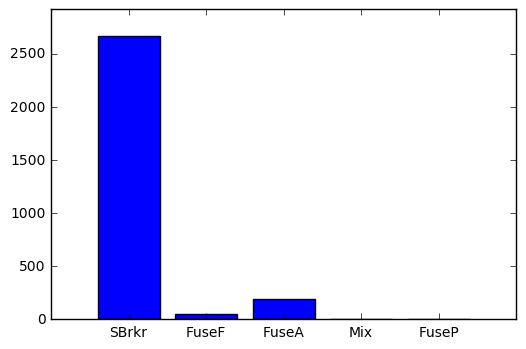

In [35]:
plot_freqs(freq_electrical.keys(), freq_electrical.values(), sum(freq_electrical.values()))

Observamos que la variable *Electrical* está muy desbalanceada, en su mayor parte las observaciones corresponden a la categoría *SBrkr*.

La categoría mayoritaria es *SBrkr*, podríamos imputar este valor, pero vamos a seguir inspeccionando los datos para asegurarnos de que elegimos el valor mas apropiado para imputar el missing detectado en esta variable.

Veamos qué valores toman algunas de las variables que intuitivamente sospechamos puedan tener relación con *Electrical*

In [56]:
miss_electrical.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 
                       'YearRemodAdd']).show(1)
                        
miss_electrical.select(['MSZoning', 'Heating', 'CentralAir', 'MiscFeature', 'Electrical']).show(1)

+--------+----------+-----------+-----------+---------+------------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|
+--------+----------+-----------+-----------+---------+------------+
|    1Fam|      SLvl|          5|          5|     2006|        2007|
+--------+----------+-----------+-----------+---------+------------+

+--------+-------+----------+-----------+----------+
|MSZoning|Heating|CentralAir|MiscFeature|Electrical|
+--------+-------+----------+-----------+----------+
|      RL|   GasA|         Y|       None|      null|
+--------+-------+----------+-----------+----------+



La variable *MiscFeature* la hemos incluido para comprobar si la vivienda tenía alguna instalación con necesidades eléctricas especiales, pero comprobamos que no es así. 

La variable *MSZoning* la añadimos para comprobar que la vivienda no estaba situada en una zona agrícola o industrial con características especiales que pudieran influir en la instalación electrica, pero comprobamos que no es asi.

*Heating* toma el valor *GasA*, por lo que no se utiliza la instalación eléctrica para la calefacción de la vivienda, sin embargo *CentralAir* toma el valor *Y*, por lo que podría necesitar unas características especiales en cuanto a sistema eléctrico.

Después de inspeccionar los valores anteriores vamos a comprobar cómo se distribuyen las categorias de Electrical cuando la vivienda fue construida (*YearBuilt*) o remodelada (*YearRemodAdd*) a partir del año 2006. También filtraremos por las variables *OverallQual* y *OverallCond*, que nos dan idea de las calidades de la vivienda. También filtraremos por *Heating* y *CentralAir*. 

El resto de variables consultadas no las tendremos en cuenta en el filtro porque parecen bastantes genéricas y no aportan demasiada información.

In [73]:
no_miss_electrical.filter(
    ((no_miss_electrical.YearBuilt >= 2006) | (no_miss_electrical.YearRemodAdd >= 2006))&
    ((no_miss_electrical.OverallQual== 5) | (no_miss_electrical.OverallCond==5)) &
    ((no_miss_electrical.BldgType=='1Fam') | (no_miss_electrical.HouseStyle=='SLvl')) &
    (no_miss_electrical.Heating=='GasA') & (no_miss_electrical.CentralAir=='Y')).groupBy('Electrical').count().show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     FuseF|    1|
|     SBrkr|  360|
+----------+-----+



Observamos que la clase *SBrkr* es mayoritaria para las características filtradas, por tanto, tomaremos *SBrkr* como valor de imputación para la observación faltante de la variable *Electrical*

In [74]:
imputation_dict['Electrical']='SBrkr'

### Variables missing *Exterior*

* **Exterior2nd**: cubierta exterior de la vivienda (si existe más de un material)
* **Exterior1st**: cubierta exterior de la vivienda

In [128]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Exterior' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'Exterior2nd', StringType, 0.03)
(1, 'Exterior1st', StringType, 0.03)


In [77]:
miss_exterior = full.filter(full.Exterior2nd.isNull() | full.Exterior1st.isNull())
no_miss_exterior = full.filter(full.Exterior2nd.isNotNull() & full.Exterior1st.isNotNull())

Exploraremos los valores de las variables relacionadas con *Exterior2nd* y *Exterior1st* para el registro con valor perdido.

In [80]:
miss_exterior.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MiscFeature']).show(5)
 
miss_exterior.select(['RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'MSZoning']).show(5)

+--------+----------+-----------+-----------+---------+------------+-----------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MiscFeature|
+--------+----------+-----------+-----------+---------+------------+-----------+
|    1Fam|    1Story|          5|          7|     1940|        2007|       None|
+--------+----------+-----------+-----------+---------+------------+-----------+

+---------+--------+----------+----------+---------+---------+--------+
|RoofStyle|RoofMatl|MasVnrType|MasVnrArea|ExterQual|ExterCond|MSZoning|
+---------+--------+----------+----------+---------+---------+--------+
|     Flat| Tar&Grv|      None|         0|       TA|       TA|      RL|
+---------+--------+----------+----------+---------+---------+--------+



### Variables missing *Garage*

* **GarageYrBlt**: año en el que fue construido el garage
* **GarageCars**: tamaño del garage según capacidad de coches
* **GarageArea**: tamaño del garage (ft2)

In [127]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Garage' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(159, 'GarageYrBlt', IntegerType, 5.45)
(1, 'GarageCars', IntegerType, 0.03)
(1, 'GarageArea', IntegerType, 0.03)


Vamos a estudiar en primer lugar los missings de las variables *GarageCars* y *GarageArea* que sólo presentan una observación y a continuación analizaremos los 159 registros con valores perdidos de la variable *GarageYrBlt*

In [113]:
miss_garage = full.filter(full.GarageCars.isNull() | full.GarageArea.isNull())
no_miss_garage = full.filter(full.GarageCars.isNotNull() & full.GarageArea.isNotNull())

In [114]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|
+----------+----------+----------+------------+----------+----------+-----------+



Observamos que los valores perdidos de las variables *GarageCars* y *GarageArea* pertenecen a la misma observación. En dicha observación el resto de variables relativas al garage nos informan de la no existencia de garage. En ese caso el tamaño del garage, que es lo que representan las variables que estamos estudiando, será igual a 0. 

Por tanto, decidimos imputar el valor 0 a los valores perdidos de las variables *GarageCars* y *GarageArea*, lo añadimos al diccionario *imputation_dict*.

En la inspección anterior vemos que la variable *GarageType* toma el valor *Detchd* (garage independiente a la vivienda), mientras que el resto de variables relativas al garage (*GarageQual*, *GarageCond*, etc.) toman el valor *NoGarage*, este registro no parece consistente, el valor de *GarageType* debería ser también *NoGarage*

In [144]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt', 
                    'SalePrice']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+---------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|SalePrice|
+----------+----------+----------+------------+----------+----------+-----------+---------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|     null|
+----------+----------+----------+------------+----------+----------+-----------+---------+



El valor de *SalePrice* en este registro es null, lo que quiere decir que el resgistro pertenece al conjunto test, y por tanto, no vamos a modificar a modificar el dataset, pero sí habrá que tenerlo en cuenta a la hora de realizar las predicciones con el modelo que construyamos.

In [145]:
imputation_dict['GarageCars']=0
imputation_dict['GarageArea']=0

A continuación analizaremos los valores perdidos de la variable *GarageYrBlt*

In [146]:
miss_garageYearBlt = full.filter(full.GarageYrBlt.isNull())
no_miss_garageYearBlt = full.filter(full.GarageYrBlt.isNotNull())

In [147]:
miss_garageYearBlt.select(['GarageQual',
                           'GarageCond',
                           'GarageType',
                           'GarageFinish',
                           'GarageCars',
                           'GarageArea',
                           'GarageYrBlt']).show(10)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  No

Observamos que la variable *GarageYrBlt* no toma ningún valor si la vivienda no tiene garage, evidentemente, si no tiene garage, la variable que representa el año en el que se construyo el garage carece de sentido.

Vamos a explorar los registros qu sí tienen valor para *GarageYrBlt* en busca de un año por defecto que haya sido introducido cuando la vivienda no tiene garage

In [148]:
no_miss_garageYearBlt.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', \
                             'GarageCars', 'GarageArea', 'GarageYrBlt')\
                     .filter((no_miss_garageYearBlt.GarageQual=='NoGarage')  | 
                             (no_miss_garageYearBlt.GarageCond=='NoGarage')  |
                             (no_miss_garageYearBlt.GarageType =='NoGarage') |
                             (no_miss_garageYearBlt.GarageFinish =='NoGarage') |
                             (no_miss_garageYearBlt.GarageCars == 0) |
                             (no_miss_garageYearBlt.GarageArea == 0)).show()

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
+----------+----------+----------+------------+----------+----------+-----------+



Vemos que no hay un valor por defecto para el año de construcción del garage cuando la vivienda no tiene garage.

A continuación vamos a obtener la descripción de esta variable en la parte del dataset que no tiene valores perdidos.

In [149]:
no_miss_garageYearBlt.describe('GarageYrBlt').show()

+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              2760|
|   mean|1978.1134057971014|
| stddev|25.574284723905112|
|    min|              1895|
|    max|              2207|
+-------+------------------+



Obtenemos un valor medio aproximado de año de construcción igual a *1978*. Un valor mínimo igual 1895 y un casualmente encontramos un valor máximo que representa un año en el futuro, parece que existe un outlier en la variable *GarageYrBlt*

In [150]:
train.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(train.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



In [151]:
test.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(test.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|        TA|        TA|    Attchd|         RFn|         2|       502|       2207|     2006|        2007|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



El outlier está en el conjunto test, por lo que habrá que tenerlo en cuenta a la hora de calcular las predicciones sobre este conjunto de datos una vez haymos construido y ajustado nuestro modelo. Una buena opción para corregir este registro es dar el valor *2007*, ya que a la vista de los datos, la vivienda fue construida en 2006 y remodelada en el 2007 y en ese momento se construyó el garage, parece que hay una errata en un número en lugar de 2207 debería ser 2007.


Tenemos varias alternativas a la hora de solucionar los 159 registros missing de la variable *GarageYrBlt*. 
* Imputar la media de los años = 1978
* Imputar un 0 para indicar que si la vivienda no tiene garage, el año es un valor atípico
* Eliminar la variable *GarageYrBlt*
* Predecir el año usuando árboles de decisión

Ninguna de las soluciones es buena, podríamos eliminar la variable que es lo más sencillo, pero probaremos a dar el valor 0, ya que el porcentage de registros faltantes en esta variable es bajo (5,45%) y podría proporcionar información en la construcción del modelo. Tomar la media de los años también puede introducir error. Por tanto, tomaremos 0 como valor para imputar, y en función de los resultados que obtengamos con el modelo realizaremos pruebas de imputación con otros valores diferentes.

In [152]:
imputation_dict['GarageYrBlt'] = 0

### Variable missing *KitchenQual*

* **KitchenQual**: Calidad de la cocina (Ex, Gd, TA, Fa, Po)

In [131]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'KitchenQual' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'KitchenQual', StringType, 0.03)


In [271]:
miss_kitchen = full.filter(full.KitchenQual.isNull())

In [275]:
step=11
for index in range(0, num_columns, step):
    miss_kitchen.select(cols[index:index+step]).show(5) 

+----+----------+--------+-----------+-------+------+--------+--------+-----------+---------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|   Alley|LotShape|LandContour|Utilities|LotConfig|
+----+----------+--------+-----------+-------+------+--------+--------+-----------+---------+---------+
|1556|        50|      RL|         72|  10632|  Pave|noAccess|     IR1|        Lvl|   AllPub|   Inside|
+----+----------+--------+-----------+-------+------+--------+--------+-----------+---------+---------+

+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+
|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|RoofStyle|
+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+
|      Gtl|     ClearCr|      Norm|      Norm|    1Fam|    1.5Fin|          5|          3|     1917|       

### Variable missing *SaleType*

In [132]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'SaleType' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'SaleType', StringType, 0.03)


### Variable missing *Functional*

In [133]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Functional' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(2, 'Functional', StringType, 0.07)


### Variable missing *Utilities*

In [135]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Utilities' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(2, 'Utilities', StringType, 0.07)


### Variable missing *MSZoning*

In [136]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'MSZoning' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(4, 'MSZoning', StringType, 0.14)


### Variables missing *MasVnr*

In [138]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'MasVnr' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(24, 'MasVnrType', StringType, 0.82)
(23, 'MasVnrArea', IntegerType, 0.79)


### Variable missing *LotFrontage*

In [139]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'LotFrontage' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(486, 'LotFrontage', IntegerType, 16.65)


### Imputación de valores perdidos

Añadimos al diccionario imputation_dict los valores de las categorías NA válidas pero que hemos renombrado para más claridad

In [ ]:
imputation_dict.update(new_NA_categories)

In [ ]:
imputed_df=train.fillna(imputation_dict)

<a id="preprocesado"></a>

# 5. Preprocesado

<a id="numerico"></a>

## 5.2 Conversión a tipo numérico

<a id="escalado"></a>

## 5.3 Escalado

<a id="features"></a>

## 5.4 Convertir features en vector

<a id="seleccion"></a>

# 6. Selección de variables 

(correlaciones, importancia de variables)

<a id="modelos"></a>

# 7. Modelos

<a id="ajuste"></a>

## 7.1 Ajuste de parámetros

<a id="evaluacion"></a>

## 7.2 Evaluación

La evaluación del modelo final debe hacerse con un dataset diferente al de entrenamiento. 

Se recomienda automatizar procesos mediante el uso de pipelines y creación de funciones para evitar repetir código.

La métrica a usar para la evaluación de soluciones es *RMSLE*. Esta métrica no se encuentra dentro de las que ofrece el objeto *RegressionEvaluator* por lo que debemos definir nuestro propio evaluador.

In [9]:
'''
Código original tomado de:
https://gist.github.com/pvalienteverde

- Se ha añadido la fórmula rmsle para que trabaje con la API DataFrames.
'''

from pyspark.ml.evaluation import Evaluator
from math import sqrt
from operator import add
from pyspark.sql.functions import avg
from pyspark.sql.functions import log1p

class MyEvaluator(Evaluator):
    '''
    When a userID is predicted when it is not already trained (all userID  data is used on validation 
    group and none of them to train), prediction is nan,  so RegressionEvaluator returns Nan.
    To solve this we must change RegressionEvaluator by MiValidacion
    '''
    def __init__(self,predictionCol='prediction', targetCol='rating'):        
        super(MyEvaluator, self).__init__()
        self.predictionCol=predictionCol
        self.targetCol=targetCol
        
    def _evaluate(self, dataset):       
        error=self.rmse(dataset,self.predictionCol,self.targetCol)
        print ("Error: {}".format(error))
        return error
    
    def isLargerBetter(self):
        return False
    
    @staticmethod
    def rmse(dataset, predictionCol, targetCol):
        return sqrt(dataset.select(avg((dataset[targetCol] - dataset[predictionCol]) ** 2)).first()[0])
    
    @staticmethod
    def rmsle(dataset, predictionCol, targetCol):
        return sqrt(dataset.select(avg((log1p(dataset[targetCol]) - log1p(dataset[predictionCol])) ** 2)).first()[0])             

In [10]:
evaluator = MyEvaluator()

<a id="cierre"></a>

# 8. Cierre sesión spark

Liberamos recursos

In [34]:
spark.stop()